### Sources:
 
-https://deeplearning.cs.cmu.edu/F21/document/recitation/Recitation5/CNN_Backprop_Recitation_5_F21.pdf
-https://people.ece.ubc.ca/~scottc/CPEN400DSlides/CPEN400D-Part14-cnn_backpropagation.pdf

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import confusion_matrix
import time
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy import signal

Set device and reproducibility

In [3]:
torch.manual_seed(101)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Introduction to Convolutional Neural Networks in Deep Learning
In this section I will develop an example on how to train the MNIST dataset using a model that contains convolutional layers and fully connected layers using PyTorch.

Create a transformer instance

In [4]:
transform = transforms.ToTensor()

Import the MNIST Dataset and divide into train and test data

In [5]:
train_data = datasets.MNIST(root = "train_images/MNIST", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root = "train_images/MNIST", train=False, download=True, transform=transform)

Create the dataloaders with a small batch size (for CNN)

In [6]:
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=10, shuffle=False)


### Shape of the input tensors to convolutional or polling layers

The shape of the training/test input tensors that spect the convolutional and poling PyTorch Layers is four-dimensional. With:

- batch_size: number of tensor-images in the batch
- input_channels: channels of the image i.e. 1 for grayscale, 3 for RGB.
- $h_{in}$: high of the input images
- $w_{in}$: width of the input images


$$\text{input_tensor_shape} = (\text{batch_size}, \text{input_channels}, h_{in}, w_{in})$$

In example, the shape of the first input tensor in the train loader:

In [7]:
for images, labels in train_loader:
    print("Shape of the first input tensor: ", images.shape)
    break

Shape of the first input tensor:  torch.Size([10, 1, 28, 28])


## Pytorch nn.Conv2d convolutional layer

Depending on the desired architecture `nn.Conv2d` requires several parameters like: the input channels, the output channels, the kernel size (filter), the stride, the padding etc. The shape of the output tensor after the convolution will be affected by this configuration. The output_channels or feature maps are the main outputs of the convolution calculated with the kernels that are initialized with random **weights**. `nn.Conv2d` also adds random **bias** terms at the end of the convolution operation. Eq(1) describe the main calculation that perform `nn.Conv2d` with `bias = True`.

\begin{eqnarray}
z[i,j] = \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} x[i+m, j+n] \cdot y[m,n] + b
\end{eqnarray}

where the output $z[i,j]$ is the result of a convolution operation between the input $x[i,j]$ and the kernel $y[m,n]$, followed by the addition of a bias term $b$. For each one of the fea

#### Example 1:
Calculate the shape of the output tensor after a convolution with this configuration. (input tensor shape = $[10, 1, 28, 28]$) 

*conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3, stride = 1, padding = 0)*
 
This configuration means:

- 1, for one input channel (grayscale)
- 6, **output channels for feature extractions, the feature maps, the filters that the CNN will figure out**
- 3, kernel size for a 3 by 3 squared filter
- 1, for the horizontal and vertical stride of the convolution
- 0, no pixels will be added to the input border

The convolutions made by pytorch Conv2d can be very flexible, and have many configurations, but if the kernel is squared the output size of a convolutional layer is determined by these parameters:

- Input size: The height and width of the input image (`h_in`, `w_in`).
- Kernel size: The height and width of the filter (`kernel_size`), usually denoted as $k$
- Stride: The step size the filter moves along the input (`stride`), denoted as $s$
- Padding: The number of pixels added to the input border (`padding`), denoted as $p$

The output size (height and width) after applying the convolution is computed by the following formula:

Height of the output after convolution
$$h_{\text{out}} = \left\lfloor \frac{h_{\text{in}} + 2p - k}{s} \right\rfloor + 1$$

Width of the output after convolution
$$w_{\text{out}} = \left\lfloor \frac{w_{\text{in}} + 2p - k}{s} \right\rfloor + 1$$

Output shape after convolution
$$\text{output_shape} = (\text{batch_size}, \text{out_channels}, h_{\text{out}}, w_{\text{out}})$$

The output tensor shape then will be:

- batch_size = 10
- out_channels = 6
- $h_{out} = \frac{28+2*0-3}{1} + 1 = 26$
- $w_{out} = \frac{28+2*0-3}{1} + 1 = 26$

$$\text{conv\_output\_shape} = (10, 6, 26, 26)$$

In [8]:
# define the convolutional layer
conv1 = nn.Conv2d(1,6,3,1)

for images, labels in train_loader:
    break

print("Shape of the convoluted tensor: ", conv1(images).shape)

Shape of the convoluted tensor:  torch.Size([10, 6, 26, 26])


## PyTorch Polling layers
The poling layers are used to reduce the number of parameters in convolutional layers performing a mapping in the input tensor (like the convolution operation) but this time averaging or using the maximum instead of summing. The input of a polling layer is a convolutional layer.

In PyTorch, pooling layers like `MaxPool2d` or `AvgPool2d` downsample the input using a kernel (or window) and stride (how far the window moves).
For a simple squared kernel the formula for the output shape of a polling layer is the same for a convolutional layer.

### Example 2:
Calculate the shape of the output tensor after a convolution with this configuration. (input tensor shape = $[10, 6, 26, 26]$)

*pol1 = f.MaxPool2d(input = conv1, kernel_size = 2, stride = 2, padding = 0)*

Output shape after polling
$$\text{output_shape} = (\text{batch_size}, \text{out_channels}, h_{\text{out}}, w_{\text{out}})$$

The output tensor shape then will be:

- batch_size = 10
- out_channels = 6
- $h_{out} = \frac{26+2*0-2}{2} + 1 = 13$
- $w_{out} = \frac{26+2*0-2}{2} + 1 = 13$

$$\text{polling_output_shape} = (10, 6, 13, 13)$$


In [9]:
pol1 = F.max_pool2d(input=conv1(images), kernel_size=2, stride=2)
print("Shape of the pooled tensor: ", pol1.shape)

Shape of the pooled tensor:  torch.Size([10, 6, 13, 13])


## From polling layers to fully connected layers 
To perform a leaning task the tensor must be flattened to reach this shape 

$$\text{input_to_dense_layer} = (\text{batch_size}, \text{all_tensors_per_batch})$$ 

in order to pass the tensor to a fully connected or dense layer.

The `.view()` method for tensors can be used to reshape a multidimensional tensor using as a positional parameter `-1`. With `-1` `.view()` will guess a dimension based on the other explicit parameters. 

The *in_features* of the fully connected layer then must be equal to $\text{all_tensors_per_batch}$

### Example 3:
Reshape a polled tensor to fit in a fully connected layer with *out_features = 120* (pooled tensor shape = $[10,6,13,13]$).



In [10]:
batch_size = 10

# reshape to [10, 6*13*13]
x = pol1.view(batch_size, -1)
print("Shape after the flattening", x.shape)

# create a fully connected layer with in_features = 6*13*13 and out_features = 120
fcl = nn.Linear(x.size(1),120)
print("Fully Connected layer setup:", fcl)

# perform a forward pass
x = fcl(x)

Shape after the flattening torch.Size([10, 1014])
Fully Connected layer setup: Linear(in_features=1014, out_features=120, bias=True)


### Forward and backward pass in convolutional layers
The out_features or feature maps can be the input for another layers, then a computation graph that represent the forward and backward pass could be: 

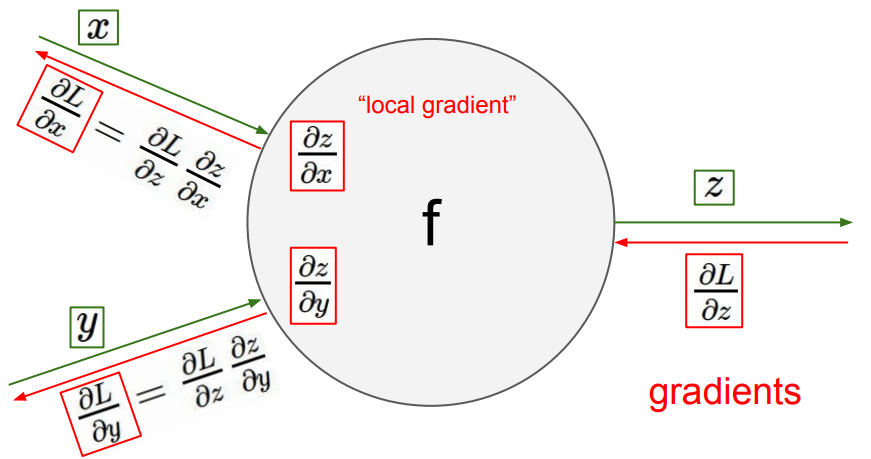

In [11]:
Image("images/backpropagation_graph.png")

where

- $x$: the input tensor image
- $y$: the filter or kernel  
- $*$: the convolution operation (x * y)
- $L$: the loss function
- $z$: the out_feature of feature map, the result of the convolution
- $\frac{\partial L}{\partial z}$ : the derivative of the loss with respect to the out_feature is already known

### Gradients of the loss with respect to the filter $\frac{\partial L}{\partial y}$ and the input $\frac{\partial L}{\partial x}$

Using the generalized chain rule the gradient of $L$ W.R.T. each component $i$ of the filter $y$:

<br>

$$
\begin{eqnarray}
\frac{\partial L}{\partial y_i} = \sum_{k = 1}^{M} \frac{\partial L}{\partial z_k} \frac{\partial z_k}{\partial y_i}
\end{eqnarray}
$$

<br>

Using the generalized chain rule the gradient of $L$ W.R.T. each component $i$ of the input $x$ :

<br>

$$
\begin{eqnarray}
\frac{\partial L}{\partial x_i} = \sum_{k = 1}^{M} \frac{\partial L}{\partial z_k} \frac{\partial z_k}{\partial x_i}
\end{eqnarray}
$$

<br>

### Example 4
 
#### Forward pass: convolution $z = x * y$

*assuming that the filter is already flipped*

<br>
<br>

$$
\text{Input Tensor } x = 
\begin{array}{|c|c|c|}
\hline
x_{11} & x_{12} & x_{13} \\
\hline
x_{21} & x_{22} & x_{23} \\
\hline
x_{31} & x_{32} & x_{33} \\
\hline
\end{array}
\quad
\text{Filter } y = 
\begin{array}{|c|c|}
\hline
y_{11} & y_{12} \\
\hline
y_{21} & y_{22} \\
\hline
\end{array}
$$

<br>
<br>

$$
z = x*y =
\begin{array}{|c|c|c|}
\hline
x_{11} & x_{12} & x_{13} \\
\hline
x_{21} & x_{22} & x_{23} \\
\hline
x_{31} & x_{32} & x_{33} \\
\hline
\end{array}
\quad * \quad
\begin{array}{|c|c|}
\hline
y_{11} & y_{12} \\
\hline
y_{21} & y_{22} \\
\hline
\end{array}
$$

<br>
<br>

$$z_{11} = x_{11}y_{11} + x_{12}y_{12} + x_{21}y_{21} + x_{22}y_{22}$$

$$
z_{12} = x_{12}y_{11} + x_{13}y_{12} + x_{22}y_{21} + x_{23}y_{22}
$$

$$
z_{21} = x_{21}y_{11} + x_{22}y_{12} + x_{31}y_{21} + x_{32}y_{22}
$$

$$
z_{22} = x_{22}y_{11} + x_{23}y_{12} + x_{32}y_{21} + x_{33}y_{22}
$$

<br>
<br>

#### Backward pass

Applying Eq(1). for each one of the four components of the filter: $y_{11}, y_{12}, y_{21}, y_{22}$

<br>

Gradient of the loss with respect to $y_{11}$ 

<br>

$$\frac{\partial L}{\partial y_{11}} = \sum_{k = 1}^{4} \frac{\partial L}{\partial z_k} \frac{\partial z_k}{\partial y_{11}}$$

<br>

$$
\frac{\partial L}{\partial y_{11}} = \frac{\partial L}{\partial z_{11}} \frac{\partial z_{11}}{\partial y_{11}} + \frac{\partial L}{\partial z_{12}} \frac{\partial z_{12}}{\partial y_{11}} + \frac{\partial L}{\partial z_{21}} \frac{\partial z_{21}}{\partial y_{11}} + \frac{\partial L}{\partial z_{22}} \frac{\partial z_{22}}{\partial y_{11}}
$$

<br>
<br>

Developing the first component of the sum: 

<br>
<br>

$$\frac{\partial L}{\partial z_{11}} \frac{\partial z_{11}}{\partial y_{11}} = \frac{\partial L}{\partial z_{11}} \frac{\partial [x_{11}y_{11} + x_{12}y_{12} + x_{21}y_{21} + x_{22}y_{22}]}{\partial y_{11}} = \frac{\partial L}{\partial z_{11}} \frac{\partial [x_{11}y_{11}]}{\partial y_{11}} = \frac{\partial L}{\partial z_{11}} x_{11}$$

<br>
<br>

Applying to all components of the sum:

<br>
<br>

$$
\frac{\partial L}{\partial y_{11}} = \frac{\partial L}{\partial z_{11}} \cdot x_{11} + \frac{\partial L}{\partial z_{12}} \cdot x_{12} + \frac{\partial L}{\partial z_{21}} \cdot x_{21} + \frac{\partial L}{\partial z_{22}} \cdot x_{22}
$$

<br>
<br>

Calculating the gradient of $L$ with respect to all the components of the filter $y$

<br>
<br>

$$
\frac{\partial L}{\partial y_{11}} = \frac{\partial L}{\partial z_{11}} \cdot x_{11} + \frac{\partial L}{\partial z_{12}} \cdot x_{12} + \frac{\partial L}{\partial z_{21}} \cdot x_{21} + \frac{\partial L}{\partial z_{22}} \cdot x_{22}
$$

$$
\frac{\partial L}{\partial f_{12}} = \frac{\partial L}{\partial z_{11}} \cdot x_{12} + \frac{\partial L}{\partial z_{12}} \cdot x_{13} + \frac{\partial L}{\partial z_{21}} \cdot x_{22} + \frac{\partial L}{\partial z_{22}} \cdot x_{23}
$$

$$
\frac{\partial L}{\partial f_{21}} = \frac{\partial L}{\partial z_{11}} \cdot x_{21} + \frac{\partial L}{\partial z_{12}} \cdot x_{22} + \frac{\partial L}{\partial z_{21}} \cdot x_{31} + \frac{\partial L}{\partial z_{22}} \cdot x_{32}
$$

$$
\frac{\partial L}{\partial f_{22}} = \frac{\partial L}{\partial z_{11}} \cdot x_{22} + \frac{\partial L}{\partial z_{12}} \cdot x_{23} + \frac{\partial L}{\partial z_{21}} \cdot x_{32} + \frac{\partial L}{\partial z_{22}} \cdot x_{33}
$$

<br>
<br>

Through this example one can clearly see that the result of $\frac{\partial L}{\partial y}$ can be viewed as an **internal convolution without flipping or an internal cross correlation** between the input tensor $x$ and $\frac{\partial L}{\partial z}$ because the kernel was already flipped in the forward pass. 

<br>
<br>

$$
\begin{array}{|c|c|}
\hline
\frac{\partial L}{\partial y_{11}} & \frac{\partial L}{\partial y_{12}} \\
\hline
\frac{\partial L}{\partial y_{21}} & \frac{\partial L}{\partial y_{22}} \\
\hline
\end{array} = x* \frac{\partial L}{\partial z} =
\begin{array}{|c|c|c|}
\hline
x_{11} & x_{12} & x_{13} \\
\hline
x_{21} & x_{22} & x_{23} \\
\hline
x_{31} & x_{32} & x_{33} \\
\hline
\end{array}
\quad * \quad
\begin{array}{|c|c|}
\hline
\frac{\partial L}{\partial z_{11}} & \frac{\partial L}{\partial z_{12}} \\
\hline
\frac{\partial L}{\partial z_{21}} & \frac{\partial L}{\partial z_{22}} \\
\hline
\end{array}
$$

<br>
<br>

The calculation of the gradients of the loss with respect to the $x$ input tensor can be made following the same logic used in the calculation of the gradients of the loss with respect to the filter $y$ and using the Eq.(2). But this time to put in the same order the components of the $x$ tensor altered by the convolution in the forward pass a convolution will be performed instead of a cross correlation. The sources contain complete descriptions about the computational graph of the forward and backward pass in CNNs including the forward and backward pass of the `bias` term. 

<br>
<br>

$$
\begin{array}{|c|c|c|}
\hline
\frac{\partial L}{\partial x_{11}} & \frac{\partial L}{\partial x_{12}} & \frac{\partial L}{\partial x_{13}} \\
\hline
\frac{\partial L}{\partial x_{21}} & \frac{\partial L}{\partial x_{22}} & \frac{\partial L}{\partial x_{23}} \\
\hline
\frac{\partial L}{\partial x_{31}} & \frac{\partial L}{\partial x_{32}} & \frac{\partial L}{\partial x_{33}} \\
\hline
\end{array} 
=
y * \frac{\partial L}{\partial z} 
=
\begin{array}{|c|c|}
\hline
y_{22} & y_{21} \\
\hline
y_{12} & y_{11} \\
\hline
\end{array}
\quad * \quad
\begin{array}{|c|c|}
\hline
\frac{\partial L}{\partial z_{11}} & \frac{\partial L}{\partial z_{12}} \\
\hline
\frac{\partial L}{\partial z_{21}} & \frac{\partial L}{\partial z_{22}} \\
\hline
\end{array} 
$$

<br>
<br>

In Most cases the shape of the $x$ tensor is higher than the shape of the filter and $\frac{\partial L}{\partial z}$ so an **external convolution or full convolution** taking count the appropriate padding and stride is suitable to calculate the gradients.

The next code shows how to calculate the gradients of $L$ with respect to $x$ and $y$ using convolutions with $\frac{\partial L}{\partial z}$ and the `backward()` method.

In [34]:
# Input tensor x (3x3) and filter f (2x2) as leaf tensors (requires_grad=True)
x = torch.tensor([[1.0, 2.0, 3.0], 
                  [4.0, 5.0, 6.0], 
                  [7.0, 8.0, 9.0]], requires_grad=True).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 3, 3)

y = torch.tensor([[1.0, 0.0], 
                  [0.0, -1.0]], requires_grad=True).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 2, 2)

# Convolution operation (forward pass)
z = F.conv2d(x, y)

# Make sure that the gradients are tracked for the input, filter and the output_feature 
x.retain_grad()
y.retain_grad()
z.retain_grad()

# Define loss (for example, we sum the elements of z as a dummy loss)
L = z.mean()

# Backward pass 
L.backward()

# Gradients
print(f"Gradients with respect to the filter f:\n{y.grad}")
print(f"Gradients with respect to the input x:\n{x.grad}")
print(f"Gradients with respect to the convolution z:\n{z.grad}")

y_grad_num = y.grad.view(2,2).detach().numpy()
x_grad_num = x.grad.view(3,3).detach().numpy()
z_grad_num = z.grad.view(2,2).detach().numpy()

y_num = y.detach().view(2,2).numpy()
x_num = x.detach().view(3,3).numpy()

gradient_scipy_filter = signal.convolve2d(x_num, z_grad_num, mode="valid") # valid for internal convolution 
gradient_scipy_input = signal.convolve2d(y_num, z_grad_num, mode="full") # full to make an external convolution

print("Scipy convolution to get the gradient of the filter", gradient_scipy_filter)
print("Scipy convolution to get the gradient of the input", gradient_scipy_input)

Gradients with respect to the filter f:
tensor([[[[3., 4.],
          [6., 7.]]]])
Gradients with respect to the input x:
tensor([[[[ 0.2500,  0.2500,  0.0000],
          [ 0.2500,  0.0000, -0.2500],
          [ 0.0000, -0.2500, -0.2500]]]])
Gradients with respect to the convolution z:
tensor([[[[0.2500, 0.2500],
          [0.2500, 0.2500]]]])
Scipy convolution to get the gradient of the filter [[3. 4.]
 [6. 7.]]
Scipy convolution to get the gradient of the input [[ 0.25  0.25  0.  ]
 [ 0.25  0.   -0.25]
 [ 0.   -0.25 -0.25]]


### CNN Model
There can be may possible configurations of Convolutional Layers and Poling Layers. To train the MNIST dataset a common architecture is:

CL -> POL -> CL -> POL -> FLAT -> FCL1 -> FCL2 -> FCL3

To parametrize the number of filters the method `_initialize_fc1` emulates the forward pass with a dummy input to get the flattened size of the output of the last convolutional or polling layer.



In [9]:
class ConvolutionalNN(nn.Module):
    def __init__(self, filter1, filter2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, filter1, 3, 1)  # change this to any number of filters
        self.conv2 = nn.Conv2d(6, filter2, 3, 1) #  change this to any number of filters
        self.pool = nn.MaxPool2d(2, 2)
        
        # Initialize fully connected layers with placeholder
        self.fc1 = None
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # Dynamically compute the input size for the first fully connected layer
        self._initialize_fc1()

    def _initialize_fc1(self):
        # Create a dummy tensor with the same size as an MNIST input
        dummy_input = torch.zeros(1, 1, 28, 28)

        # Pass the dummy input through the conv and pooling layers to calculate the flattened size
        dummy_output = self.pool(F.relu(self.conv1(dummy_input)))
        dummy_output = self.pool(F.relu(self.conv2(dummy_output)))
        
        # Calculate the flattened size
        flattened_size = dummy_output.numel()  # Returns the total number of elements in the tensor
        
        # Now that we know the flattened size, we can initialize the first fully connected layer
        self.fc1 = nn.Linear(flattened_size, 120)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.pool(X)  
        X = F.relu(self.conv2(X))
        X = self.pool(X)  
        X = X.view(X.size(0), -1)  # Flattening
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

Model instance

In [10]:
model = ConvolutionalNN(filter1=6, filter2=16).to(device)
print(model)

ConvolutionalNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
)


Loss function and optimizer

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Backpropagation in a model with Convolutional Layers and Fully Connected Layers

<br>

#### Loss computation:
The output from the final fully connected layer (`fc3`) is used to compute the loss. 
In the model the loss is computed after applying `log_softmax` at the output layer. 

#### Backpropagation through fully connected layers
The gradient of the loss with respect to the output from `fc3` is computed and propagated backward to compute the gradients of weights and biases for the fully connected layers.

For the weights in `fc3`:

<br>

$\frac{\partial{Loss}}{\partial{W_{3}}} = \frac{\partial{Loss}}{\partial{\hat{y}}} \cdot \frac{\partial{\hat{y}}}{\partial{W_{3}}}$

where $\hat{y}$ is the output after the final layer.

The gradients are computed for all the fully connected layers sequentially during backpropagation: `fc3` gradients are computed first, followed by `fc2`, and then `fc1`.

#### Backpropagation thought the flattened output (Reshaping back into convolutional outputs)

Once the gradient reaches the flattened input (after `fc1`), PyTorch "reshapes" it back into the original size before the flattening operation. This is done internally, and it allows gradients to propagate back into the convolutional layers. 

For example, if the flattened vector was $1 \times 400$, the reshaped gradient will have the shape of the output from the second pooling layer.

#### Backpropagation through convolutional layers:
After reshaping the gradient back, it is propagated through the convolutional layers.

Just like in fully connected layers, PyTorch computes the gradient with respect to the weights and biases of the convolutional layers during backpropagation.

### Training Loop

In [12]:
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # train 
    for b, (X_trn, Y_trn) in enumerate(train_loader):
        X_trn, Y_trn = X_trn.to(device), Y_trn.to(device)  # Ensure inputs and targets are on the same device
        b += 1
        
        y_pred = model(X_trn)  # Fixed typo: use X_trn instead of X_train
        loss = criterion(y_pred, Y_trn)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == Y_trn).sum()  # Corrected from y_pred to Y_trn
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b % 600 == 0:
            print(f'epoch: {b:2} - batch: {b:4} [{10*b:6}/60000],  loss: {loss.item():.6f}, accuracy: {trn_corr.item()*100/(10*b):.6f}%')
    
    
    train_losses.append(loss.item())
    train_correct.append(trn_corr)  # Use trn_corr instead of batch_corr for the entire epoch
        
    # test
    with torch.no_grad():
        for b, (X_test, Y_test) in enumerate(test_loader):
            X_test, Y_test = X_test.to(device), Y_test.to(device)  # Ensure test inputs and targets are on the same device
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == Y_test).sum()
        
    loss = criterion(y_val, Y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr)
        
current_time = time.time()
total = current_time - start_time
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch: 600 - batch:  600 [  6000/60000],  loss: 0.080591, accuracy: 79.750000%
epoch: 1200 - batch: 1200 [ 12000/60000],  loss: 0.208541, accuracy: 86.558333%
epoch: 1800 - batch: 1800 [ 18000/60000],  loss: 0.182700, accuracy: 89.438889%
epoch: 2400 - batch: 2400 [ 24000/60000],  loss: 0.278924, accuracy: 90.925000%
epoch: 3000 - batch: 3000 [ 30000/60000],  loss: 0.224449, accuracy: 91.966667%
epoch: 3600 - batch: 3600 [ 36000/60000],  loss: 0.099626, accuracy: 92.713889%
epoch: 4200 - batch: 4200 [ 42000/60000],  loss: 0.067769, accuracy: 93.311905%
epoch: 4800 - batch: 4800 [ 48000/60000],  loss: 0.258688, accuracy: 93.816667%
epoch: 5400 - batch: 5400 [ 54000/60000],  loss: 0.016685, accuracy: 94.216667%
epoch: 6000 - batch: 6000 [ 60000/60000],  loss: 0.004168, accuracy: 94.503333%
epoch: 600 - batch:  600 [  6000/60000],  loss: 0.299413, accuracy: 97.533333%
epoch: 1200 - batch: 1200 [ 12000/60000],  loss: 0.127280, accuracy: 97.691667%
epoch: 1800 - batch: 1800 [ 18000/60000], 

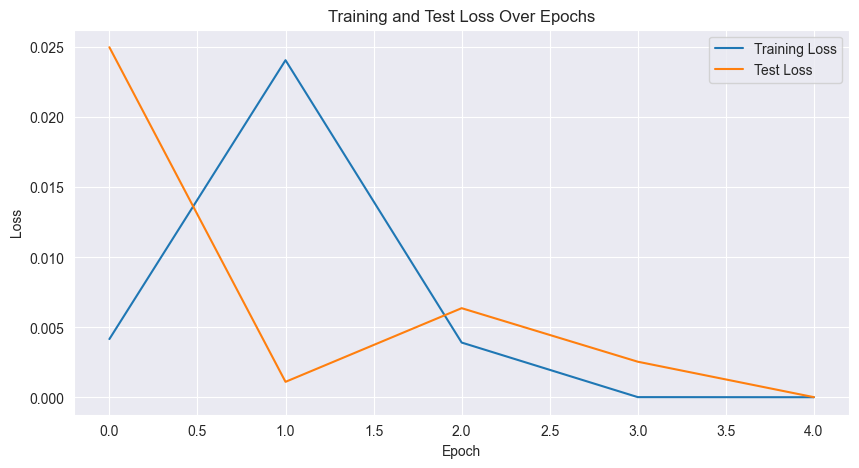

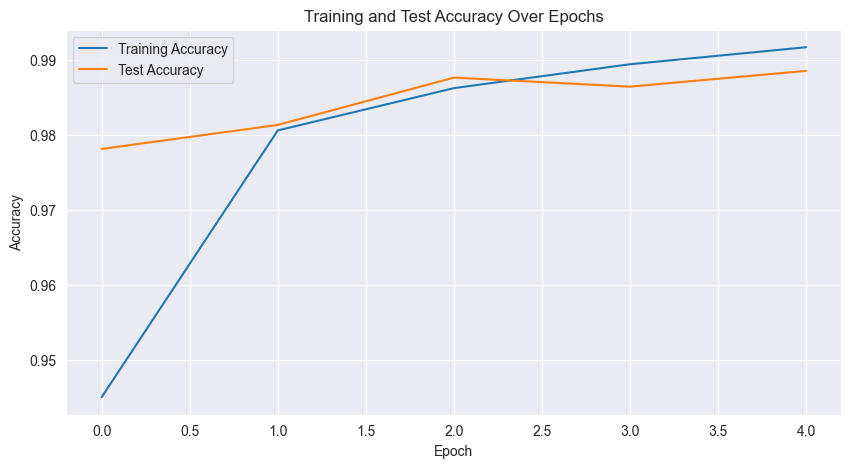

In [13]:


# Plot training and testing loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and testing accuracy
train_acc = [float(x) / len(train_data) for x in train_correct]  # Convert to accuracy percentages
test_acc = [float(x) / len(test_data) for x in test_correct]  # Convert to accuracy percentages

plt.figure(figsize=(10,5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Evaluation with the entire test data

In [14]:
# Extract the data all at one
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test, Y_test in test_load_all:
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == Y_test).sum()
print(f'Entire Test Dataset Accuracy: {correct.item()/len(test_data)} = {correct.item()*100/(len(test_data)):.7f}%')

Entire Test Dataset Accuracy: 0.9885 = 98.8500000%


In [15]:
# count the number of parameters used in the model
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

    54
     6
   864
    16
 10080
    84
   840
    10
 48000
   120
______
 60074


Confusion Matrix

In [16]:
def print_confusion_matrix():
    np.set_printoptions(formatter=dict(int=lambda x: f"{x:4}"))
    print(np.arange(10).reshape(1,10))
    print()

    # Move tensors to CPU and convert to numpy for confusion matrix computation
    predicted_cpu = predicted.view(-1).cpu().numpy()
    y_test_cpu = Y_test.view(-1).cpu().numpy()

    # Print the confusion matrix
    print(confusion_matrix(predicted_cpu, y_test_cpu))

In [17]:
print_confusion_matrix()

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 974    0    1    0    0    2    6    0    3    1]
 [   0 1131    2    0    0    0    2    4    1    1]
 [   1    0 1022    2    0    0    0    9    5    0]
 [   0    0    0 1006    0    8    0    1    1    1]
 [   0    1    0    0  972    0    1    0    1    5]
 [   2    0    0    1    0  877    3    0    2    8]
 [   2    2    4    0    4    5  946    0    1    0]
 [   1    1    2    1    0    0    0 1013    2    2]
 [   0    0    1    0    0    0    0    0  953    0]
 [   0    0    0    0    6    0    0    1    5  991]]


In [18]:
def print_sample(ide):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        # Ensure the input tensor is moved to the same device as the model
        device = next(model.parameters()).device
        input_tensor = test_data[ide][0].view(1, 1, 28, 28).to(device)
        
        # Perform the prediction and move the result to CPU and NumPy
        new_prediction = model(input_tensor).argmax().cpu().numpy()

    # Move the image tensor to the CPU, convert to NumPy, and reshape for display
    plt.imshow(test_data[ide][0].cpu().numpy().reshape(28, 28), cmap='gray')
    
    # Print the predicted class
    print(f"Prediction: {new_prediction}")

Prediction: 5


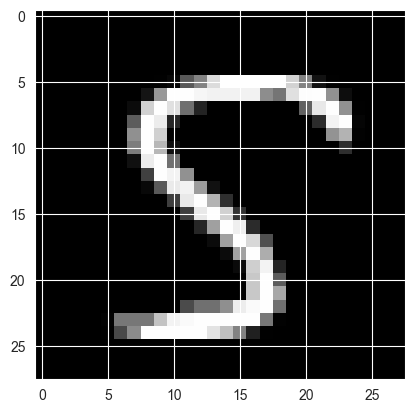

In [19]:
print_sample(333)